In [16]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')

In [17]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [18]:
import plotly.graph_objects as go

def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Precio en dolares"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()

# Importación de datos

In [19]:
import yfinance as yf

ticker_name = 'BC'

data = yf.download(ticker_name, start='2003-06-01', end='2013-06-01')
print(data.shape)
data.head()

[*********************100%%**********************]  1 of 1 completed

(2518, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-06-02,22.080000,22.490000,22.049999,22.200001,16.651119,519800
2003-06-03,22.200001,22.480000,22.200001,22.400000,16.801128,327000
2003-06-04,22.370001,23.139999,22.370001,23.000000,17.251165,444100
2003-06-05,22.900000,23.240000,22.799999,23.150000,17.363665,394200
2003-06-06,25.010000,25.080000,24.100000,24.150000,18.113716,905600


In [20]:
df = pd.DataFrame()
df["Date"] = pd.to_datetime(data.index)
df["Close"] = data["Close"].values
display(df.head(10))
display(df.shape)

df_completo = df.copy()
df_completo.set_index('Date', inplace=True)
df_completo = df_completo.resample('1D').mean().ffill()
display(df_completo.head(10))
df_completo.shape

,Date,Close
0,2003-06-02,22.200001
1,2003-06-03,22.400000
2,2003-06-04,23.000000
3,2003-06-05,23.150000
4,2003-06-06,24.150000
5,2003-06-09,24.540001
6,2003-06-10,24.660000
7,2003-06-11,25.120001
8,2003-06-12,25.090000
9,2003-06-13,25.170000


(2518, 2)

,Close
Date,
2003-06-02,22.200001
2003-06-03,22.400000
2003-06-04,23.000000
2003-06-05,23.150000
2003-06-06,24.150000
2003-06-07,24.150000
2003-06-08,24.150000
2003-06-09,24.540001
2003-06-10,24.660000


(3652, 1)

Segmentación de Datos: Los datos se dividen en tres conjuntos:

- Entrenamiento (70%)
- Validación (15%)
- Prueba (15%)


In [21]:

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df_completo)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)

train_data = df_completo.iloc[:train_size]
val_data = df_completo.iloc[train_size:train_size+val_size]
test_data = df_completo.iloc[train_size+val_size:]

plot_("Train and Test Data",
      (train_data.index, train_data['Close'], "Train Data"),
      (test_data.index, test_data['Close'], "Test Data"),
      (val_data.index, val_data['Close'], "Validation Data"))

Este código utiliza un **Árbol de Decisión** para predecir los precios de cierre de una serie temporal financiera. Los datos se dividen en **70% para entrenamiento**, **15% para validación** y **15% para prueba**. Se ajustan dos hiperparámetros: el **`lag`** (número de retardos en las características) y **`max_depth`** (profundidad máxima del árbol). La búsqueda se realiza mediante una búsqueda de cuadrícula, evaluando combinaciones de **lag** en el rango de 1 a 20 y **depth** también en el rango de 1 a 20, buscando la combinación que minimiza el **error cuadrático medio (MSE)** en el conjunto de validación.

Una vez encontrados los mejores valores de **lag** y **depth**, el modelo se entrena con estos parámetros en los datos combinados de entrenamiento y validación, y se evalúa en los conjuntos de entrenamiento, validación y prueba. Se genera un gráfico de **predicciones versus valores reales** y se visualiza el **árbol de decisión** final. El análisis de los residuos se realiza para evaluar la **autocorrelación** y la **tendencia** de los residuos, garantizando que el modelo capture adecuadamente los patrones de la serie. **Se observa un rendimiento similar entre los conjuntos de entrenamiento, validación y prueba.**


Best lag: 1
Best depth: 6
Training - R2: 0.9987, MSE: 0.2399
Validation - R2: 0.9771, MSE: 0.2784
Test - R2: 0.9882, MSE: 0.3441


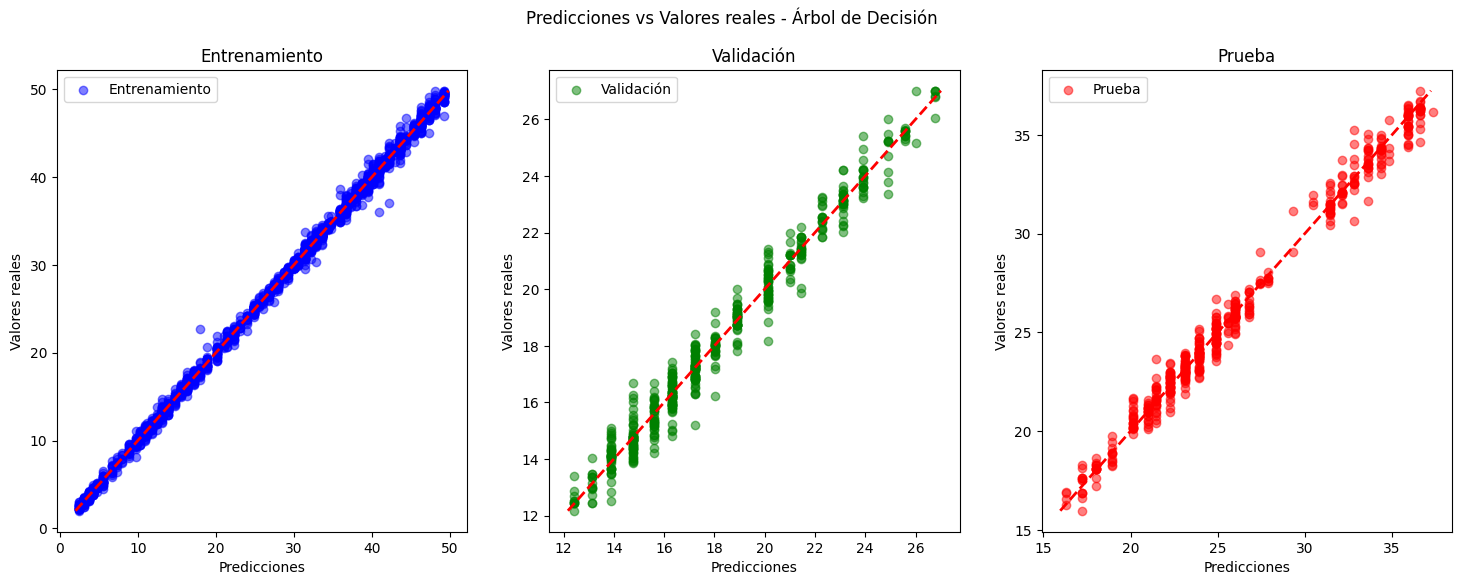

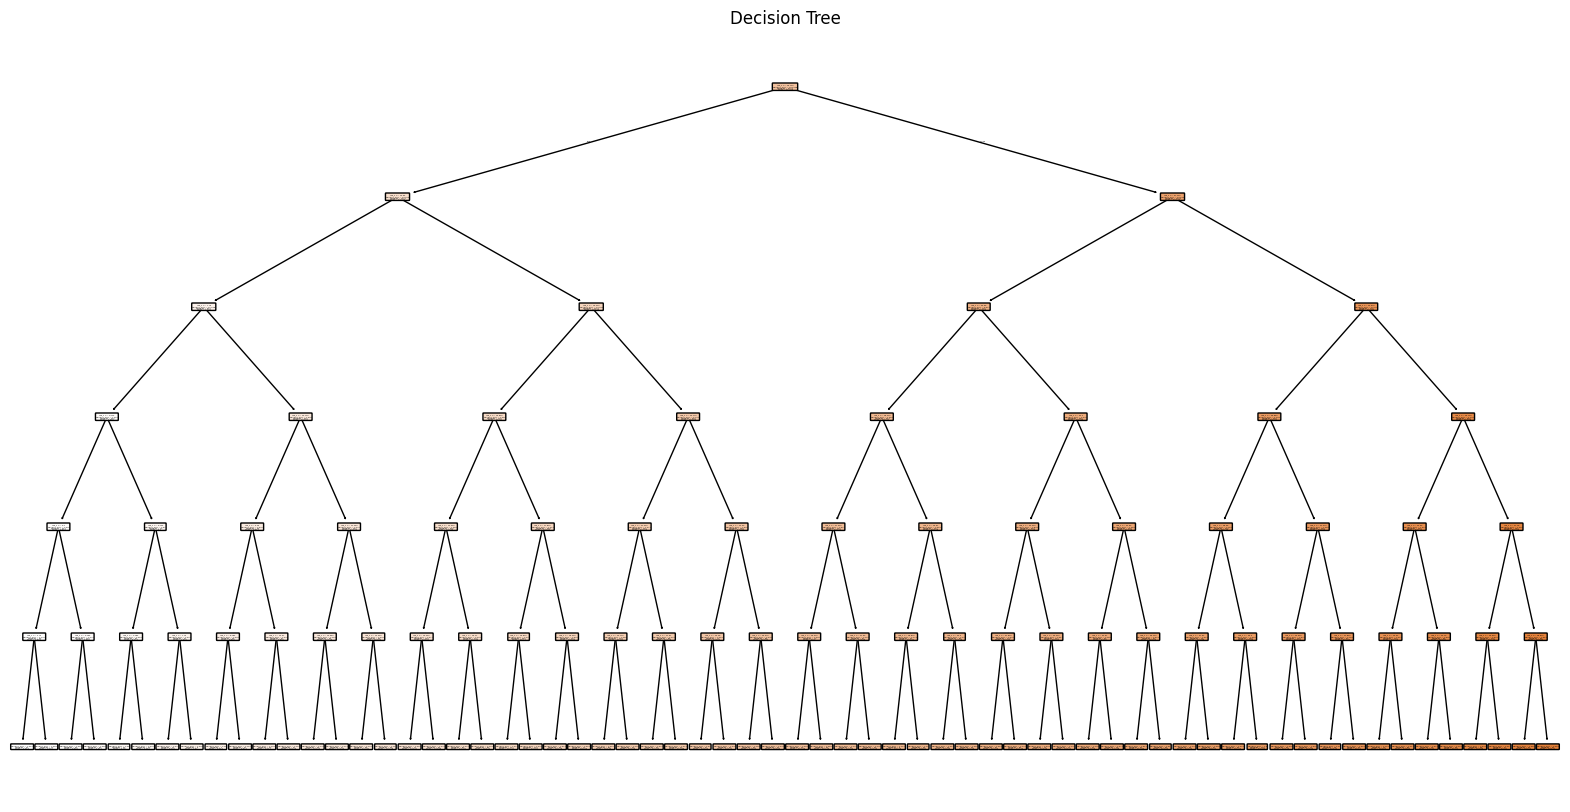

In [22]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming df_completo is already defined as mentioned

def create_features(data, lag):
    df = pd.DataFrame(index=data.index)
    df['target'] = data['Close']
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = data['Close'].shift(i)
    return df.dropna()

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df_completo)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)

train_data = df_completo.iloc[:train_size]
val_data = df_completo.iloc[train_size:train_size+val_size]
test_data = df_completo.iloc[train_size+val_size:]

# Function to evaluate the model
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    return mse, r2, predictions

# Search for the best lag and depth simultaneously
best_lag = 0
best_depth = 0
best_val_mse = np.inf

for lag in range(1, 21):
    # Create features for train and validation sets
    train_features = create_features(train_data, lag)
    val_features = create_features(val_data, lag)

    # Separate features (X) and target (y)
    X_train = train_features.drop('target', axis=1)
    y_train = train_features['target']
    X_val = val_features.drop('target', axis=1)
    y_val = val_features['target']

    for depth in range(1, 21):
        # Train the model with current lag and depth
        model = DecisionTreeRegressor(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)

        # Evaluate the model on the validation set
        val_mse, val_r2, _ = evaluate_model(model, X_val, y_val)

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_lag = lag
            best_depth = depth

print(f"Best lag: {best_lag}")
print(f"Best depth: {best_depth}")

# Create final features with the best lag
train_features = create_features(train_data, best_lag)
val_features = create_features(val_data, best_lag)
test_features = create_features(test_data, best_lag)

# Separate features (X) and target (y)
X_train = train_features.drop('target', axis=1)
y_train = train_features['target']
X_val = val_features.drop('target', axis=1)
y_val = val_features['target']
X_test = test_features.drop('target', axis=1)
y_test = test_features['target']

# Train the final model with the best depth
final_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Evaluate the model on training, validation, and test sets
train_mse, train_r2, train_pred = evaluate_model(final_model, X_train, y_train)
val_mse, val_r2, val_pred = evaluate_model(final_model, X_val, y_val)
test_mse, test_r2, test_pred = evaluate_model(final_model, X_test, y_test)

print(f"Training - R2: {train_r2:.4f}, MSE: {train_mse:.4f}")
print(f"Validation - R2: {val_r2:.4f}, MSE: {val_mse:.4f}")
print(f"Test - R2: {test_r2:.4f}, MSE: {test_mse:.4f}")

data_sets = [
    ('Entrenamiento', train_pred, y_train, 'blue'),
    ('Validación', val_pred, y_val, 'green'),
    ('Prueba', test_pred, y_test, 'red')
]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (title, pred, true, color) in enumerate(data_sets):
    axs[i].scatter(pred, true, alpha=0.5, label=title, color=color)
    axs[i].plot([true.min(), true.max()], [true.min(), true.max()], 'r--', lw=2)
    axs[i].set_xlabel('Predicciones')
    axs[i].set_ylabel('Valores reales')
    axs[i].set_title(title)
    axs[i].legend()

plt.suptitle('Predicciones vs Valores reales - Árbol de Decisión')
plt.show()

# Asumiendo que tienes una función plot_ definida
test_date = test_data.index + pd.DateOffset(days=best_lag)
plot_("Predicciones de la Serie Temporal",
      (test_data.index, test_data['Close'], "Datos de Prueba"),
      (test_date, test_pred, "Predicciones"))

plt.figure(figsize=(20, 10))
plot_tree(final_model, filled=True, feature_names=X_train.columns, rounded=True)
plt.title("Decision Tree")
plt.show()

residuals = y_test - test_pred

Los resultados muestran que el mejor **lag** encontrado es 1 y la mejor **depth** es 6. El modelo presenta un **R2** muy alto en el conjunto de entrenamiento (**0.9987**), indicando que se ajusta extremadamente bien a los datos de entrenamiento, con un **MSE** bajo de **0.2399**. En el conjunto de validación, el **R2** es **0.9771** y el **MSE** es **0.2784**, lo que sugiere una buena generalización pero con una ligera pérdida de precisión en comparación con el entrenamiento. Finalmente, en el conjunto de prueba, el **R2** es **0.9882** y el **MSE** es **0.3441**, lo que indica un buen desempeño general del modelo, aunque con una ligera degradación en el error, posiblemente debido a la variabilidad en datos no vistos durante el entrenamiento. En general, el modelo muestra un rendimiento robusto y consistente a través de los diferentes conjuntos de datos.


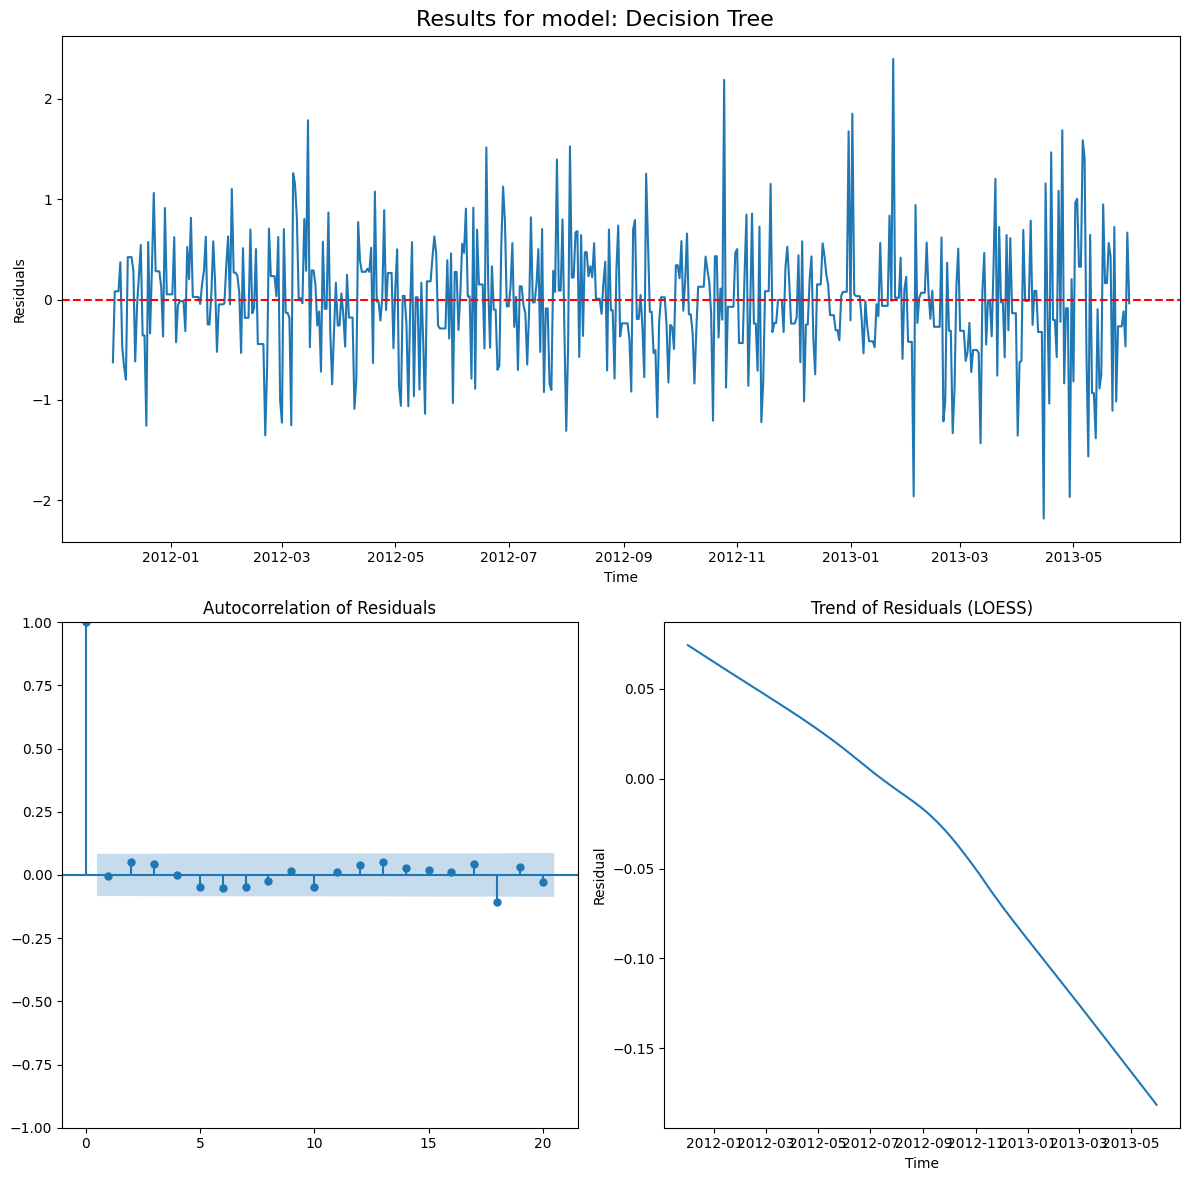

,Model,Lag,MSE,Depth
0,Decision Tree,1,0.344138,6


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_residuals_and_stats(residuals_series, title, fig, axs, best_lag, best_depth, mse):
    # Configure the figure title
    fig.suptitle(f'Results for model: {title}', fontsize=16)

    # Residuals vs Time
    axs["A"].plot(residuals_series)
    axs["A"].set_xlabel('Time')
    axs["A"].set_ylabel('Residuals')
    axs["A"].axhline(0, color='red', linestyle='--')

    # Autocorrelation of Residuals using statsmodels
    sm.graphics.tsa.plot_acf(residuals_series.values, lags=20, ax=axs["B"])
    axs["B"].set_title('Autocorrelation of Residuals')

    # LOESS trend of Residuals
    lowess = sm.nonparametric.lowess(residuals_series.values, np.arange(len(residuals_series)), frac=0.75)
    axs["C"].plot(residuals_series.index, lowess[:, 1])
    axs["C"].set_title('Trend of Residuals (LOESS)')
    axs["C"].set_xlabel('Time')
    axs["C"].set_ylabel('Residual')

    plt.tight_layout()

    # Create DataFrame with model details
    model_df = pd.DataFrame({
        'Model': ['Decision Tree'],
        'Lag': [best_lag],
        'MSE': [mse],
        'Depth': [best_depth]
    })

    return model_df

# Example usage:
# Assuming you have already calculated residuals, best_lag, best_depth, and mse

# Create the figure and subplots
fig, axs = plt.subplot_mosaic("AA;BC", figsize=(12, 12))

# Call the function with the residuals series and model title
model_df = plot_residuals_and_stats(residuals, "Decision Tree", fig, axs, best_lag, best_depth, test_mse)

# Display the plot
plt.show()

# Display the model details DataFrame
model_df

Se observa discrepancias mayores en el 2013-02, positiva sy  negativas respectivamente, aunque explica claramente la tendencia, pero en el lag 17 una posible autocorrelación no capturada por el modelo, lo que podría explicar la discrepancia en el rendimiento.